**Installation of SimPy""
If not available**

In [39]:
pip install simpy

Note: you may need to restart the kernel to use updated packages.


**Import of required modules**

In [40]:
import simpy
import numpy as np
import numpy.random as random

**Parameters settings**

In [41]:
MAXSIMTIME = 50000
VERBOSE = False
LAMBDA = 4
MU = 6
POPULATION = 50000000
SERVICE_DISCIPLINE = 'FIFO'
LOGGED = True
PLOTTED = True

**Discrete-Event Simulation model**


**The definition of a job**.

The properties of a job are


1. job execution time
2. job arrival time

In [42]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

**Disciplines**
Different queue disciplines can be defined here.


1.   Shortest Job First (SJF)
2.   List item



In [43]:
def SJF( job ):
    return job.duration

**The definition of server**

 There are 2 arguments needed for a server:
 1. env: SimPy environment
 2. queue discipline: 
   - FIFO: First In First Out
   - SJF : Shortest Job First

In [44]:
class Server:
    def __init__(self, env, qlog,strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        self.isBusy = False
        self.qlog = qlog
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        self.responseTime = 0

        ''' register a new server process '''
        env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.isBusy = False
                self.serversleeping = self.env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
                self.isBusy = True
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )
                if LOGGED:
                    self.qlog.write( '%.4f\t%d\t%d\n' 
                        % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                ''' yield an event for the job finish'''
                yield self.env.timeout( j.duration )
                ''' sum up the jobs done '''
                self.responseTime += self.env.now - j.arrtime
                self.jobsDone += 1

    def waiting(self, env):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                 print('Server waken up and works at %.2f' % self.env.now )

**The arrival process**

The arrival process is exponentially distributed which is parameterized by
1. number of servers
2. maximum number of population
3. arrival rate $\lambda$
4. service rate $\mu$
*Note that, the implementation of the arrival process embeds both arrival and service distributions.*

In [45]:
class JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 5, mu = 8):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam;
        self.servicetime = 1/mu;
        env.process( self.generatejobs(env) )
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            self.server.Jobs.append( Job('Job %s' %i, env.now, job_duration) )
            if VERBOSE:
                print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    %( i, env.now, job_duration, job_interarrival ) )
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )


**Open the log file**

If requested.

In [46]:
if LOGGED:
    qlog_1 = open( 'parallel-l%d-m%d_1.csv' % (LAMBDA/2,MU), 'w' )
    qlog_1.write( '0\t0\t0\n' )
    qlog_2 = open( 'parallel-l%d-m%d_2.csv' % (LAMBDA/2,MU), 'w' )
    qlog_2.write( '0\t0\t0\n' )

**Start SimPy environment**

In [47]:
env = simpy.Environment()
MyServer_1 = Server( env, qlog_1, SERVICE_DISCIPLINE )
MyServer_2 = Server( env, qlog_2, SERVICE_DISCIPLINE )
MyJobGenerator_1 = JobGenerator( env, MyServer_1, POPULATION, LAMBDA/2, MU )
MyJobGenerator_2 = JobGenerator( env, MyServer_2, POPULATION, LAMBDA/2, MU )

**Run the simulation** 

In [48]:
env.run( until = MAXSIMTIME )

**Close the log file**

In [49]:
if LOGGED:
    qlog_1.close()
    qlog_2.close()

**Print some statistics**

In [50]:
RHO = (LAMBDA/2)/MU
print( 'Arrivals Server 1              : %d' % (MyServer_1.jobsDone) )
print( 'Utilization Server 1           : %.2f/%.2f' 
    % (1.0-MyServer_1.idleTime/MAXSIMTIME, RHO) )
print( 'Mean waiting time Server 1     : %.2f/%.2f' 
    % (MyServer_1.waitingTime/MyServer_1.jobsDone, RHO**2/((1-RHO)*(LAMBDA/2)) ) )

print( 'Mean response time                                  : %.2f/%.2f' 
    % (MyServer_1.responseTime/MyServer_1.jobsDone, (1/MU)/(1-RHO)) )

print( 'Mean service time                                   : %.2f/%.2f' 
    % ((MyServer_1.responseTime - MyServer_1.waitingTime)/MyServer_1.jobsDone, (1/MU)/(1-RHO) - RHO**2/((1-RHO)*(LAMBDA/2))) )

print( 'Mean numbers of jobs in the system                  : %.2f/%.2f' 
    % (MyServer_1.responseTime/MAXSIMTIME, RHO/(1-RHO)) )

print( 'Mean numbers of jobs in the queue - Queue length    : %.2f/%.2f' 
    % (MyServer_1.waitingTime/MAXSIMTIME, RHO**2/(1-RHO)) )


print( 'Arrivals Server 2              : %d' % (MyServer_2.jobsDone) )
print( 'Utilization Server 2           : %.2f/%.2f' 
    % (1.0-MyServer_2.idleTime/MAXSIMTIME, RHO) )
print( 'Mean waiting time Server 2     : %.2f/%.2f' 
    % (MyServer_2.waitingTime/MyServer_2.jobsDone, RHO**2/((1-RHO)*(LAMBDA/2)) ) )

print( 'Mean response time                                  : %.2f/%.2f' 
    % (MyServer_2.responseTime/MyServer_2.jobsDone, (1/MU)/(1-RHO)) )

print( 'Mean service time                                   : %.2f/%.2f' 
    % ((MyServer_2.responseTime - MyServer_2.waitingTime)/MyServer_2.jobsDone, (1/MU)/(1-RHO) - RHO**2/((1-RHO)*(LAMBDA/2))) )

print( 'Mean numbers of jobs in the system                  : %.2f/%.2f' 
    % (MyServer_2.responseTime/MAXSIMTIME, RHO/(1-RHO)) )

print( 'Mean numbers of jobs in the queue - Queue length    : %.2f/%.2f' 
    % (MyServer_2.waitingTime/MAXSIMTIME, RHO**2/(1-RHO)) )

systemResponseTime = (MyServer_1.responseTime/MyServer_1.jobsDone + MyServer_2.responseTime/MyServer_2.jobsDone)/2
systemWaitingTime = (MyServer_1.waitingTime/MyServer_1.jobsDone + MyServer_2.waitingTime/MyServer_2.jobsDone)/2
systemServiceTime = systemResponseTime - systemWaitingTime


meanNJobsInSystem = (MyServer_1.responseTime/MyServer_1.jobsDone + MyServer_2.responseTime/MyServer_2.jobsDone)
meanNJobsInQueue = (MyServer_1.waitingTime/MAXSIMTIME + MyServer_2.waitingTime/MAXSIMTIME)

print( 'Response time of system     : %.2f' %(systemResponseTime))
print( 'Waiting time of system      : %.2f' %(systemWaitingTime))
print( 'Service time of system      : %.2f' %(systemServiceTime))
print( 'Mean njobs of system        : %.2f' %(meanNJobsInSystem))
print( 'Mean njobs of queue         : %.2f' %(meanNJobsInQueue))



Arrivals Server 1              : 99666
Utilization Server 1           : 0.33/0.33
Mean waiting time Server 1     : 0.08/0.08
Mean response time                                  : 0.25/0.25
Mean service time                                   : 0.17/0.17
Mean numbers of jobs in the system                  : 0.50/0.50
Mean numbers of jobs in the queue - Queue length    : 0.16/0.17
Arrivals Server 2              : 100552
Utilization Server 2           : 0.34/0.33
Mean waiting time Server 2     : 0.09/0.08
Mean response time                                  : 0.25/0.25
Mean service time                                   : 0.17/0.17
Mean numbers of jobs in the system                  : 0.51/0.50
Mean numbers of jobs in the queue - Queue length    : 0.17/0.17
Response time of system     : 0.25
Waiting time of system      : 0.08
Service time of system      : 0.17
Mean njobs of system        : 0.50
Mean njobs of queue         : 0.34


**Plot the statistics**

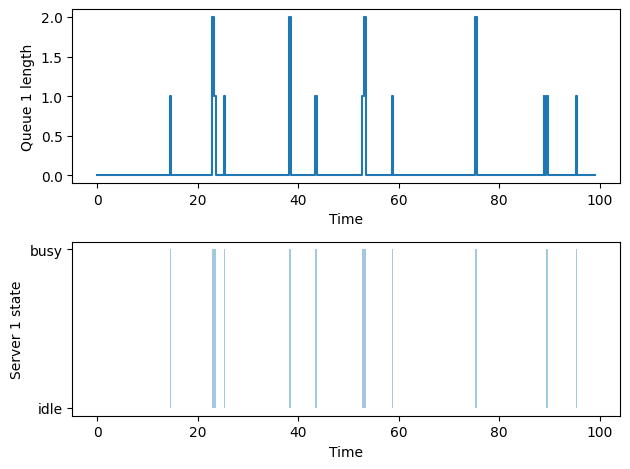

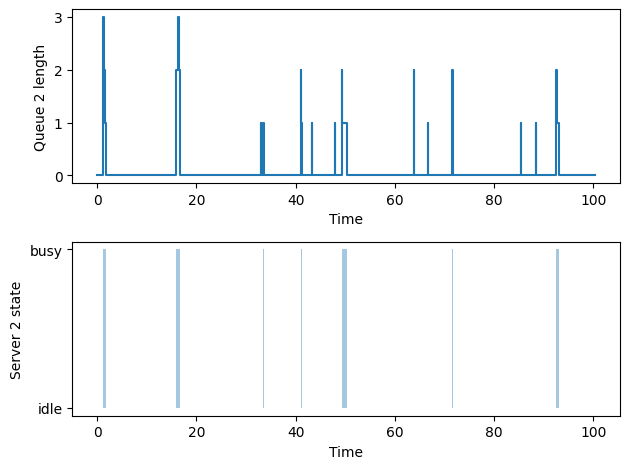

In [51]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    log = np.loadtxt( 'parallel-l%d-m%d_1.csv' % (LAMBDA/2,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue 1 length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server 1 state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()

    log = np.loadtxt( 'parallel-l%d-m%d_2.csv' % (LAMBDA/2,MU), delimiter = '\t' )
    plt.subplot( 2, 1, 1 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Queue 2 length' )
    plt.step( log[:200,0], log[:200,2], where='post' )
    plt.subplot( 2, 1, 2 )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Server 2 state' )
    plt.yticks([0, 1], ['idle', 'busy'])
    #plt.step( log[:200,0], log[:200,1], where='post' )
    plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4 )
    plt.tight_layout()
    plt.show()